## Data
***
### Import Libraries

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import holidays
from workalendar.europe import UnitedKingdom
import warnings

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (18,7)

***
### Functions

In [4]:
def get_yf_data(ticker:str, start:str, end:str, column:str = None):
    """
    Retrieve historical financial data for a given stock ticker symbol within a specified date range.

    Parameters:
        ticker (str, required): The ticker symbol fo the stock you want to return
        start  (str, required): The start date of the historical data range in 'YYYY-MM-DD' format.
        end    (str, required): The end date of the historical data range in 'YYYY-MM-DD' format.
        column (str, optional): The specific data column to retrieve (e.g., 'Open', 'Close').
                                If None (default), returns a DataFrame with all available columns.
    Returns:
        pandas.DataFrame: returns a pandas DataFrame containing data for that specific column or all columns.
    """
    
    if column == None:
        return yf.Ticker(ticker).history(start=start, end=end)
    else:
        return yf.Ticker(ticker).history(start=start, end=end)[column]
    
def log_cols(df, columns):
    for col in columns:
        df[col] = np.log(df[col])
        
def normalise_cols(df, columns):
    for col in columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
        
def get_returns(column):
    return column.pct_change()
        

***
### Stocks

In [31]:
stocks = {'HWG.L' : None, # HWG.L  - Harworth Group PLC
          'BLND.L': None, # BLND.L - British Land Company PLC
          'SGRO.L': None, # SGRO.L - Segro PLC
          'BOOT.L': None, # BOOT.L - Henry Boot PLC
          'DLN.L' : None} # DLN.L  - Derwent London PLC

palette = {'HWG.L' :'#002d61',
          'BLND.L': '#017FAC', 
          'SGRO.L': '#CC171F', 
          'BOOT.L': '#0026d1',    
          'DLN.L' : '#6a6a6a'} 

In [32]:
for i in stocks.keys():
    stocks[i] = get_yf_data(i, '2016-01-01', '2022-12-31', 'Close')
    #stocks[i] = np.log(stocks[i])
    #stocks[i].plot(color=palette[i], linewidth=1.75)
    
#plt.legend(stocks)
#plt.title('Close Price of 5 UK REITS between 2018 and 2023')
#plt.xlabel('Date')
#plt.ylabel('Close Price')
#plt.show()

log_stocks = stocks.copy()
for i in log_stocks.keys():
    log_stocks[i] = np.log(stocks[i])
    #log_stocks[i].plot(color=palette[i], linewidth=1.75)

#plt.legend(log_stocks)
#plt.title('Log of Close Price of 5 UK REITS between 2018 and 2023')
#plt.xlabel('Date')
#plt.ylabel('Log Close Price')
#plt.show()

***
### Cleaning Stock Data

In [33]:
def check_missing_values():
    
    uk = UnitedKingdom()
    check_df = pd.DataFrame(columns=['Nulls', 'Missing Dates', 'Missing Workdays'], index=list(stocks.keys()))
    
    for i in stocks.keys():
        stock = pd.DataFrame(stocks[i])

        check_df.loc[i]['Nulls'] = stock['Close'].isnull().sum()
        missing_dates = pd.date_range(start='2018-01-01', end='2022-12-31').difference(stock.index)
        check_df.loc[i]['Missing Dates'] = len(missing_dates)
        missing = 0
        for d in missing_dates:
            if d.weekday() < 5:
                if uk.is_working_day(d):
                    print('Missing Date in %s: %s' % (i, d))
                    missing += 1
        check_df.loc[i]['Missing Workdays'] = missing

    return check_df

In [34]:
check_missing_values()

Missing Date in SGRO.L: 2021-07-29 00:00:00


Nulls Missing Dates Missing Workdays
HWG.L      0           563                0
BLND.L     0           563                0
SGRO.L     0           564                1
BOOT.L     0           563                0
DLN.L      0           563                0

In [35]:
sgro = pd.DataFrame(stocks['SGRO.L'])

prev_day = pd.DataFrame(data={'Close' : sgro.loc['2021-07-28 00:00:00']['Close'], 'Date' : '2021-07-29 00:00:00'}, index=[0])
prev_day['Date'] = pd.to_datetime(prev_day['Date']) 
prev_day.index = prev_day['Date']
del prev_day['Date']

stocks['SGRO.L'] = stocks['SGRO.L'].append(prev_day['Close'])

In [36]:
check_missing_values()

Nulls Missing Dates Missing Workdays
HWG.L      0           563                0
BLND.L     0           563                0
SGRO.L     0           563                0
BOOT.L     0           563                0
DLN.L      0           563                0

***
### Inflation
[CPIH Annual Rate](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23)

In [12]:
# load CPIH Annual Rate (Inflation Rate) Data
inflation = pd.read_csv('series-160823 - CPIH.csv')[181:].reset_index(drop=True)

# change month format to full datetimes
inflation['Title'] = inflation['Title'].apply(lambda x: datetime.strftime(datetime.strptime(x, '%Y %b'), '%Y-%m-%d'))
# change column names
inflation = inflation.rename(columns={'Title': 'inf_month', 'CPIH ANNUAL RATE 00: ALL ITEMS 2015=100': 'CPIH Annual Rate'})

# adjust data types
inflation['inf_month'] = pd.to_datetime(inflation['inf_month'])
inflation['CPIH Annual Rate'] = pd.to_numeric(inflation['CPIH Annual Rate'])

# filter for 2018-2023
inflation = inflation[(inflation['inf_month']>='2016-01-01') & (inflation['inf_month']<='2022-12-31')]

***
### House Price Index
[UK Gov House Price Index](https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-march-2023#download-the-data)

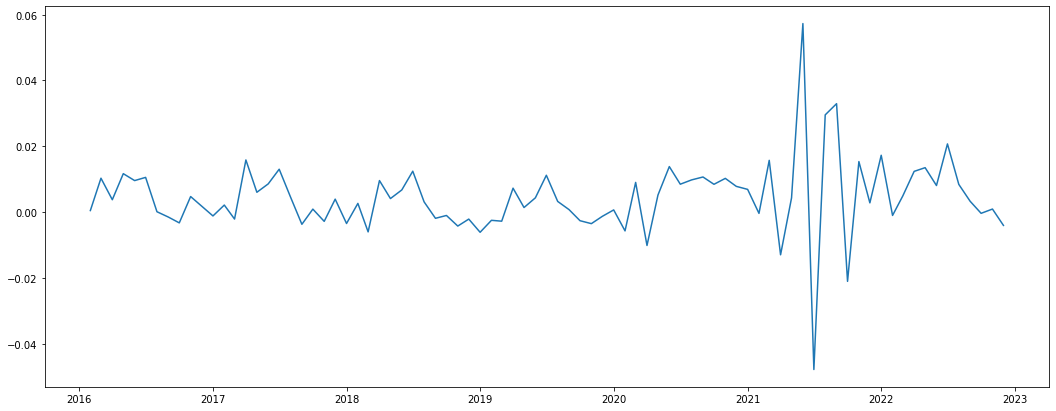

In [18]:
# load HPI data
hpi = pd.read_csv('UK-HPI-full-file-2023-03.csv')

# filter for UK records and only date and average price and index columns
hpi = hpi[hpi['RegionName']=='United Kingdom'] 
hpi = hpi[['Date','Index']]

# adjust data types
hpi['Date'] = pd.to_datetime(hpi['Date'])
hpi['Date'] = hpi['Date'].apply(lambda x: datetime.strftime(x, '%Y-%d-%m'))
hpi['Date'] = pd.to_datetime(hpi['Date'])
hpi['Index'] = pd.to_numeric(hpi['Index'])

# rename date column
hpi = hpi.rename(columns={'Date':'hpi_date'})

# filter for 2018-2023
hpi = hpi[(hpi['hpi_date'] >= '2016-01-01') & (hpi['hpi_date'] <= '2022-12-31')]
plt.plot(hpi['hpi_date'], hpi['Index'].pct_change())

***
### BoE Rates
[Bank of England Bank Rate](https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp)

In [14]:
# load BoE data
boe = pd.read_csv('Bank Rate history and data  Bank of England Database.csv')

# adjust data types
boe['Date Changed'] = pd.to_datetime(boe['Date Changed'])

# fill missing dates
full_date_range = pd.date_range(start=boe['Date Changed'].min(), end=boe['Date Changed'].max())
missing_dates = full_date_range.difference(boe['Date Changed'])
boe = boe.set_index('Date Changed')
boe = boe.reindex(full_date_range, method='ffill')

# replace date column
boe['boe_date'] = boe.index
boe = boe.reset_index(drop=True)
 
# filter for 2018-2023
boe = boe[(boe['boe_date'] >= '2016-01-01') & (boe['boe_date'] <= '2022-12-31')]

***
### GDP
[Monthly UK DGP](https://www.ons.gov.uk/economy/grossdomesticproductgdp/bulletins/gdpmonthlyestimateuk/may2023)

In [19]:
# load Monthly UK GDP Data
gdp = pd.read_csv('UK_GDP.csv', skiprows=6)

# re-format date and rename columns
gdp['Date'] = gdp['Date'].apply(lambda x: datetime.strptime(x,'%b-%y').strftime('%m/%d/%Y'))
gdp['Date'] = pd.to_datetime(gdp['Date'])
gdp = gdp.rename(columns={'Date':'gdp_date', 'Monthly GDP':'GDP'})

# filter for 2018-2023
gdp = gdp[(gdp['gdp_date'] >= '2016-01-01') & (gdp['gdp_date'] <= '2022-12-31')]

***
### FTSE 100

In [20]:
ftse = get_yf_data('^FTSE', '2016-01-01', '2022-12-31', 'Close')#.plot()
ftse = pd.DataFrame(ftse)
ftse.loc['2020-12-22'] = [ftse.loc['2020-12-21']['Close']]
ftse.index = pd.to_datetime(ftse.index)
ftse = ftse.sort_index()
ftse
#ftse['Date'] = ftse.index
#ftse = ftse.reset_index(level=0, drop=True)


Close
Date                   
2016-01-04  6093.399902
2016-01-05  6137.200195
2016-01-06  6073.399902
2016-01-07  5954.100098
2016-01-08  5912.399902
...                 ...
2022-12-22  7469.299805
2022-12-23  7473.000000
2022-12-28  7497.200195
2022-12-29  7512.700195
2022-12-30  7451.700195

[1768 rows x 1 columns]

***
### Unemployment
[UK Unemployment Data](https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms)

In [21]:
# load unemployment data
unemployment = pd.read_csv('series-280823 - unemployment.csv')[832:].reset_index(drop=True)

# rename columns
unemployment = unemployment.rename(columns={'Title':'unemp_month',
                                            'Unemployment rate (aged 16 and over, seasonally adjusted): %':'Unemployment'})

# adjust data types
unemployment['Unemployment'] = pd.to_numeric(unemployment['Unemployment'])
unemployment['unemp_month'] = pd.to_datetime(unemployment['unemp_month'])

# filter for 2018-2023
unemployment = unemployment[(unemployment['unemp_month'] >= '2016-01-01') & (unemployment['unemp_month'] <= '2022-12-31')]

## Data Consolidation

In [22]:
def add_time_series(main_df, main_date, add_df, add_date, add_date_freq):
    if add_date_freq == 'Month':
        merge_df = pd.merge(main_df.assign(grouper=main_df[main_date].dt.to_period('M')),
                            add_df.assign(grouper=add_df[add_date].dt.to_period('M')),
                            how='left', on='grouper')
    elif add_date_freq == 'Quarter':
        merge_df = pd.merge(main_df.assign(grouper=main_df[main_date].dt.to_period('Q')),
                            add_df.assign(grouper=add_df[add_date].dt.to_period('Q')),
                            how='left', on='grouper')
    elif add_date_freq == "Daily":
        add_df = add_df.rename(columns={add_date:'Date'})
        merge_df = pd.merge(main_df, add_df, how='left', on=main_date)        
        
    return merge_df

In [28]:
for i in stocks.keys():
    stock = pd.DataFrame(stocks[i])
    stock['Date'] = stock.index
    stock = add_time_series(stock, 'Date', unemployment, 'unemp_month', 'Month')
    stock = add_time_series(stock, 'Date', inflation,    'inf_month',   'Month')
    stock = add_time_series(stock, 'Date', gdp,          'gdp_date',    'Month')
    stock = add_time_series(stock, 'Date', boe,          'boe_date',    'Daily')
    stock = add_time_series(stock, 'Date', ftse,         'ftse_date',   'Daily')
    stock = add_time_series(stock, 'Date', hpi,          'hpi_date',    'Month')
    stock = stock[['Date', 'Unemployment', 'CPIH Annual Rate', 'GDP', 'Rate', 'Index', 'Close_y', 'Close_x']]
    stock = stock.rename(columns={'CPIH Annual Rate':'Inflation', 'Rate':'BoE Rate', 'Close_y':'FTSE', 'Close_x':'Close'})
    stock.index = stock['Date']
    del stock['Date']
    stocks[i] = stock

In [29]:
s = stocks['HWG.L']
s[s['FTSE'].isnull()]
stocks['HWG.L'].loc['2020-12-22']['FTSE'] = stocks['HWG.L'].loc['2020-12-21']['FTSE']
#s[s['FTSE'].isnull()]

In [39]:
#for stock in stocks.keys():
#    stocks[stock] = stocks[stock]['Close']

portfolio_closes = pd.concat([x for x in stocks.values()], axis=1)
portfolio_closes.columns = ['HWG', 'BLND', 'SGRO', 'BOOT', 'DLN']

for col in portfolio_closes.columns:
    portfolio_closes[col] = portfolio_closes[col].pct_change()#/portfolio_closes[col].shift(1)
    
    
portfolio_closes = portfolio_closes.dropna()#.plot()
portfolio_closes = portfolio_closes*100
#portfolio_closes = np.log(portfolio_closes)
portfolio_closes

HWG      BLND      SGRO      BOOT       DLN
Date                                                        
2016-01-05  0.000000  1.816987  1.038252 -2.192958  1.348734
2016-01-06 -4.040409 -1.657082  0.163450  0.896854 -0.869067
2016-01-07  0.000000 -1.165614 -1.095816  0.111112 -2.027419
2016-01-08  1.052633 -1.853074 -0.872232 -0.110989 -2.656601
2016-01-11  0.000000 -0.067433 -0.023782 -2.222214 -1.350169
...              ...       ...       ...       ...       ...
2022-12-22  0.000000 -0.356138 -1.305145  0.000000 -0.086060
2022-12-23 -1.904765  0.612715  0.502513 -0.851070  1.119732
2022-12-28  0.970872  0.482109  0.315791  0.000000  0.085180
2022-12-29  0.000000  0.580801  1.521506  1.072968  1.106369
2022-12-30  1.923080 -0.803406 -1.343676 -0.212314 -0.336695

[1767 rows x 5 columns]

In [38]:
portfolio_closes = portfolio_closes.dropna()
weights = np.random.random(len(portfolio_closes.columns))
weights /= np.sum(weights)
portfolio_closes['portfolio'] = portfolio_closes.dot(weights)
portfolio_closes

HWG      BLND      SGRO      BOOT       DLN  portfolio
Date                                                                   
2016-01-05  0.000000  1.816987  1.038252 -2.192958  1.348734   0.229165
2016-01-06 -4.040409 -1.657082  0.163450  0.896854 -0.869067  -0.905957
2016-01-07  0.000000 -1.165614 -1.095816  0.111112 -2.027419  -0.636677
2016-01-08  1.052633 -1.853074 -0.872232 -0.110989 -2.656601  -0.690111
2016-01-11  0.000000 -0.067433 -0.023782 -2.222214 -1.350169  -0.669856
...              ...       ...       ...       ...       ...        ...
2022-12-22  0.000000 -0.356138 -1.305145  0.000000 -0.086060  -0.417013
2022-12-23 -1.904765  0.612715  0.502513 -0.851070  1.119732  -0.213044
2022-12-28  0.970872  0.482109  0.315791  0.000000  0.085180   0.380981
2022-12-29  0.000000  0.580801  1.521506  1.072968  1.106369   0.857183
2022-12-30  1.923080 -0.803406 -1.343676 -0.212314 -0.336695  -0.302372

[1767 rows x 6 columns]

## Value-at-Risk

In [40]:
from arch import arch_model

In [41]:
def gjr_garch_var(p=1, o=1, q=1, prices=None, first_obs = None,
                  last_obs=None, start_forecast=None, horizon=1,
                  single_var=False, verbose=False):
    
    prices = prices[first_obs:]
    returns = prices.pct_change().dropna()*100
        
    model = arch_model(returns, p=p, o=o, q=q)
    result = model.fit(last_obs=last_obs, update_freq=5, disp='off')
    if verbose == True:
        print(result.summary())
    
    forecasts = result.forecast(start=start_forecast, horizon=horizon, reindex=False)
    conditional_mean = pd.DataFrame(forecasts.mean[start_forecast:]['h.%s' % horizon])
    conditional_var = pd.DataFrame(forecasts.variance[start_forecast:]['h.%s' % horizon])
    std_returns = (returns[first_obs:start_forecast] - result.params["mu"]) / result.conditional_volatility
    std_returns = std_returns.dropna()
    q = std_returns.quantile([0.01, 0.05])
    
    
    VaR = conditional_mean.values - np.sqrt(conditional_var).values * q.values[None, :]
    df = pd.DataFrame(VaR, columns=["VaR(99%)", "VaR(95%)"], index=conditional_var.index)

    df['returns'] = returns
    df['price'] = prices
    df.loc[last_obs] = [np.NaN, np.NaN, np.NaN, prices.loc[last_obs]]
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df['Limit(1%)'] = df['price'].shift(horizon) * ((100-df['VaR(99%)'])/100)
    df['Limit(5%)'] = df['price'].shift(horizon) * ((100-df['VaR(95%)'])/100)
    df = df.dropna()
    # Add new row to specific index name
    df = df[['price', 'returns', 'VaR(99%)', 'VaR(95%)', 'Limit(1%)', 'Limit(5%)']]
    
    length = len(df)
    #if length <= 10:
    #    print("%s - %s" % (start_forecast, length))
    if single_var == False:
        var =  df
    else:
        var =  df.iloc[0]
    
    return returns[first_obs:start_forecast], var

In [42]:
def plot_VaR(df, markers, labels, title, save_name=None):
    ax = (df[['VaR(99%)', 'VaR(95%)']]*-1).plot(legend=False,
                                         linestyle=':', linewidth=1.6,
                                         style=['#CD5C5C', '#9146FF'])
    
    xlim = ax.set_xlim(df.index[0], df.index[-1])
    point_colours = []
    for i, x in df.iterrows():
        if x['returns'] > -x['VaR(95%)']:
            point_colours.append(list(markers.keys())[0])
        elif x['returns'] < -x['VaR(99%)']:
            point_colours.append(list(markers.keys())[2])
        else:
            point_colours.append(list(markers.keys())[1])
    point_colours = np.array(point_colours, dtype="object")
    for colour in np.unique(point_colours):
        
        sel = point_colours == colour
        ax.scatter(
            df['returns'].index[sel],
            df['returns'].loc[sel],
            marker=markers[colour],
            c=point_colours[sel],
            label=labels[colour],
            s=sizes[colour])
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    leg = ax.legend(frameon=False, ncol=3)
    
    if save_name != None:
        plt.savefig('%s.png' % save_name)
    plt.show()
    

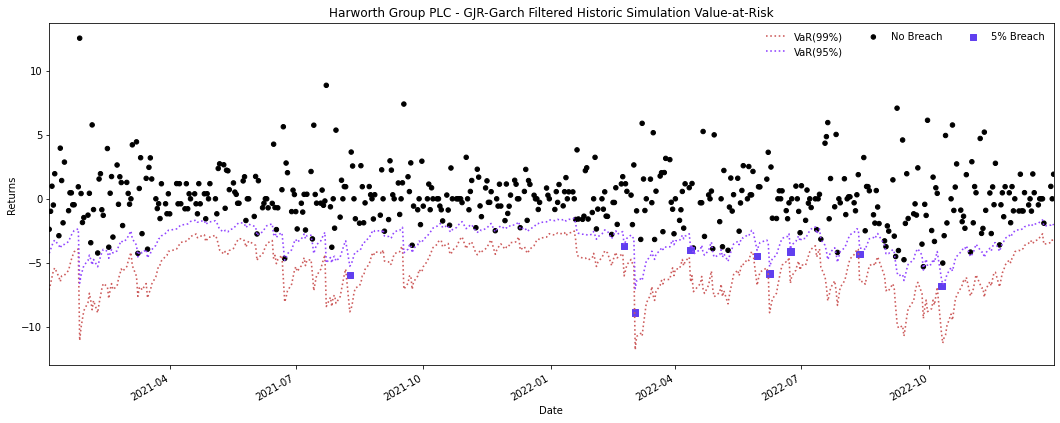

0 9 503 0.0% 1.7893%


In [44]:
markers = {"#000000": "o", "#603FEF": "s", "#FF2400": "x"}
labels = {
    "#000000": "No Breach",
    "#603FEF": "5% Breach",
    "#FF2400": "1% Breach"
    }
sizes = {
    "#000000": 20,
    "#603FEF": 40,
    "#FF2400": 40
    }

    
#hwg = portfolio_closes[['SGRO', 'HWG']] 

v = gjr_garch_var(prices=stocks['HWG.L'], first_obs='2016-05-01',
                  last_obs='2020-12-31', start_forecast='2021-01-01', horizon=1)

plot_VaR(v[1], markers, labels, 'Harworth Group PLC - GJR-Garch Filtered Historic Simulation Value-at-Risk', 'Example_GJR_Garch_FHS_VaR')

o, f, t = 0, 0, 0
for i, x in v[1].iterrows():
    t += 1
    if x['returns'] > -x['VaR(95%)']:
        pass
    elif x['returns'] < -x['VaR(99%)']:
        o += 1
    else:
        f += 1
print(o, f, t, "%s%%" % round((o/t)*100,4), "%s%%" % round((f/t)*100, 4))

## Neural Networks

In [627]:
from tqdm import tqdm
import time

In [674]:
def get_training_var(prices, model_window, no_observations, ftse):
    
    df = pd.DataFrame(prices)
    VaRs = []
    for i in tqdm(range(no_observations), desc="Loading…",ascii=False, ncols=75, position=0, leave=True):
        nrows = range(df.shape[0])
        ix = random.randint(nrows.start, nrows.stop-model_window-1)
        period = df.iloc[ix:ix+model_window, :]

        first_obs = period.index[0]
        last_obs = period.index[-1]
        start_fcs = last_obs + dt.timedelta(days=1)

        returns, var = gjr_garch_var(p=1, o=1, q=1, prices=prices,
                            first_obs=first_obs, last_obs=last_obs, start_forecast=start_fcs,
                            horizon=1, single_var=True, verbose=False)
        
        ftse_fil = ftse[first_obs:start_fcs+dt.timedelta(days=1)]
        ftse_returns = ftse_fil.pct_change().dropna()*100

        VaRs.append([[returns.values, ftse_returns.values], var['VaR(95%)']])
            
    return VaRs  

In [706]:
VaRs = get_training_var(stocks['HWG.L'], 251, 1000, ftse)  

Loading…: 100%|████████████████████████| 1000/1000 [00:49<00:00, 20.93it/s]


In [707]:
test_df = pd.DataFrame(VaRs, columns=['X', 'y'])
for i, x in test_df.iterrows():
    #print(x['X'][0], x['X'][1])
    if len(x['X'][0]) > 250:
        test_df['X'][i][0] = x['X'][0][:-1]
    if len(x['X'][1]) > 250:
        test_df['X'][i][1] = x['X'][1][:-1]
    s = test_df['X'][i][1]
    test_df['X'][i][1] = np.array([item for sub_list in s for item in sub_list])
    #print(x['X'][:250])
#test_df
#for i, x in test_df.iterrows():
#    if x['X'][0].shape[0] != 250 or x['X'][1].shape[0] != 250:
#        print(x['X'][0].shape[0])
#        print(x['X'][1].shape[0])
        #print(x['X'][1].shape[0])
    #else:
        #print(x['X'][0].shape[0])
        #print(x['X'][1].shape[0])
    #test_df.iloc[i,'X'] = x['X'][:250]#print(x['X'].shape)

[ 1.09408325 -1.73160519 -4.40527799  3.68663407  2.22221349  3.69566616
  1.04820974  1.24481169 -1.02458216  2.07038517  3.95537225  1.95122733
 -2.8708134   3.44827586 -1.42857891 -1.9323597   3.44827586 -0.47619048
  0.          0.4784689   0.         -0.47619048 -0.4784689   1.92307692
 -3.30189421  2.43903225  0.         -1.90476939  0.         -2.42717702
 -0.49751244  0.          0.         -2.          1.02040816  1.51515152
 -0.49751244 -3.00000786  4.63918374  2.95566502  0.         -1.91388312
  5.36585407 -2.7777707  -2.38095987 -0.97560216  0.98521393 -0.48779725
  1.96078431 -2.88462294  3.96040413  1.42856394 -1.87792703  2.87080588
 -0.93023263  0.46949098  0.46728237 -0.465109   -0.46729707  0.93896721
 12.55814776  0.41321664 -1.85185521 -1.46750209 -1.27659583  0.43104129
 -3.43347639  5.77777778 -0.84034274 -4.23728842  1.54867615  1.96078781
 -0.85470757 -1.29310354  3.93013814 -3.78151921  0.43668812  1.73913043
 -2.99145971  2.64317891 -0.4291913   1.72413805  1

  0.53193511  0.          0.          0.         -0.52912053] [[ 7.03429652e-01]
 [ 1.87977013e-02]
 [ 3.64375294e-01]
 [-6.81442570e-01]
 [-5.03339293e-01]
 [ 1.42870953e-01]
 [-1.45581598e-01]
 [-4.44671235e-01]
 [ 5.85780186e-01]
 [-4.76089325e-01]
 [-2.76484141e-01]
 [ 3.10994669e-01]
 [-2.52998534e-01]
 [-5.76175900e-01]
 [-5.23483005e-01]
 [ 2.20278828e+00]
 [-2.20465221e-01]
 [-7.74774042e-01]
 [ 3.00317893e-01]
 [ 1.76731480e-01]
 [-1.19119065e+00]
 [-1.12291719e+00]
 [-5.26792001e-01]
 [ 1.15514086e-01]
 [ 8.54150146e-01]
 [-2.97163582e-01]
 [ 1.53942888e+00]
 [ 2.52432000e-01]
 [ 5.85582965e-02]
 [ 1.12073652e+00]
 [-2.89376975e-02]
 [-1.32283416e+00]
 [-1.51067831e-01]
 [ 6.12537360e-01]
 [ 1.02198734e+00]
 [-2.90489030e-01]
 [ 1.22041653e+00]
 [ 1.30020484e+00]
 [-5.79562658e-01]
 [-4.73459196e-01]
 [ 6.34284319e-01]
 [ 7.53791641e-01]
 [-3.74781228e-01]
 [-6.63280530e-01]
 [-6.59165784e-01]
 [ 5.14494767e-01]
 [-9.41028845e-01]
 [ 7.55656619e-01]
 [ 3.11421328e-01]
 [ 7.12

 -1.62601794  1.23966744  0.8163209   1.21457949  1.60000173] [[ 9.22848142e-01]
 [ 5.20291363e-02]
 [-1.30005200e+00]
 [ 7.81082780e-01]
 [ 1.38539829e-01]
 [-8.01366543e-01]
 [ 3.39448782e-01]
 [ 6.55625943e-01]
 [ 1.00311289e-01]
 [-6.76756287e-02]
 [-2.99525975e-01]
 [ 6.96208030e-01]
 [-6.58965279e-01]
 [ 6.39879706e-02]
 [ 4.97176224e-01]
 [-5.19266038e-03]
 [ 6.22003960e-01]
 [-1.23760976e+00]
 [-1.00615454e+00]
 [ 1.09822195e+00]
 [ 6.13610864e-02]
 [ 7.13747706e-01]
 [ 7.54035050e-01]
 [-4.48781485e-01]
 [-9.66181076e-01]
 [-3.19551324e-01]
 [-4.04316681e-01]
 [-1.49377521e+00]
 [ 7.80218471e-01]
 [ 2.91169782e-02]
 [ 4.32615916e-01]
 [-3.37223006e-01]
 [ 1.12349152e-01]
 [-1.45229856e-01]
 [ 1.89070821e-01]
 [ 5.23922076e-01]
 [-7.08921895e-01]
 [-6.24077032e-01]
 [-1.11229507e+00]
 [ 9.71425061e-01]
 [-6.22287593e-01]
 [-1.00028290e+00]
 [-8.70881671e-01]
 [-5.64282070e-01]
 [ 2.19795998e-02]
 [-7.96753100e-02]
 [ 5.48565372e-01]
 [-4.34815614e-01]
 [ 3.07623353e-01]
 [-2.60

[ 0.          0.         -0.8968571   0.         -1.35747471  0.
  0.          0.          0.         -0.45870623  0.          0.92165495
  0.45661902  0.90908698  0.          0.45045578  0.          0.
  0.          0.          0.         -0.8968571   0.          0.
  1.35746742  0.9647614   0.          0.         -0.44443481  0.
  0.89285203  0.         -0.44248246  0.          0.          0.
  0.          0.          1.77778915 -0.87336443  0.          0.88105929
  4.36680116  0.          1.67365087  2.05761455  0.          0.
  0.40321702  0.          0.          1.60642304  0.          0.
  0.          0.          0.         -0.39525469  0.39682315  0.
  0.          0.          0.         -0.79050303  0.39839769 -0.39681678
  0.          0.39839769  0.          0.          0.79365266 -0.78740341
  0.         -0.39681678  0.39839769 -0.4999894   0.50250186  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.396823

 [ 0.30317926]]
[-1.06382433 -1.07526324  0.         -3.2608879   1.12360448 -1.11111988
 -2.24718698  0.          0.          2.29884635  0.          1.12360448
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          3.33333792 -1.07526324  0.
  0.          0.         -4.34783163  0.         -2.2727229   1.16277704
 -1.14941194  2.32557681  0.         -2.2727229  -2.32558439 -4.76191104
  3.75000519  0.         -2.40964177  1.23455349  0.          0.
  0.         -1.46340571 -3.46533855 -2.56409764 -2.10527273  3.76344081
  0.25907278  0.         -0.77519315  0.          0.          0.
 -2.60415314  1.06950604  0.          0.          1.05818865 -1.04710827
  0.          0.52910295  0.          1.57893739  0.          0.
  0.          0.         -2.84974995  0.26666358 -2.12764371  1.63045115
 -1.60429392  0.          0.         -1.63044229  1.65746632  0.
  1.63045115 -1.60429392 -5.97825297 -4.62427953 -1.81819008 -3.70370072
 -1.602566

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[ 3.89768898e-01]
 [ 6.86813196e-01]
 [ 1.75405766e-01]
 [-5.33628437e-01]
 [-7.44667098e-01]
 [ 3.70202465e-01]
 [ 2.88897111e-01]
 [ 1.11869334e-01]
 [ 3.65958575e-01]
 [ 5.97042655e-01]
 [ 9.80872301e-01]
 [ 3.39760577e-01]
 [-4.50573457e-01]
 [ 8.81906524e-01]
 [-2.00807188e+00]
 [-4.16227310e-01]
 [ 2.60528683e-01]
 [-2.91762355e-02]
 [ 5.57388011e-01]
 [ 6.20659799e-01]
 [ 5.24778904e-01]
 [ 1.00719103e+00]
 [ 3.68006206e-01]
 [-2.21073599e-01]
 [ 6.07952020e-01]
 [ 6.71420331e-02]
 [-3.52927509e-01]
 [-4.98302530e-02]
 [-5.25458763e-02]
 [ 2.57483118e-01]
 [-2.69184642e-03]
 [ 4.43733282e-01]
 [ 1.87405770e-02]
 [-1.52582585e-01]
 [ 8.47198972e-01]
 [-6.81903634e-01]
 [-5.04559919e-01]
 [-7.93626971e-02]
 [ 1.68277640e-01]
 [-3.02390896e-01]
 [-4.43509069e-01]
 [-4.60373998e-01]
 [ 3.98572956e-01]
 [-1.62724028e+00]
 [ 1.44618139e-01]
 [-8.74709086e-01]
 [-5.68873340e-02]
 [-5.49742624e-01]
 [ 1.08742550e+00]
 [ 7.65022945e-01]
 [ 7.74290804e-01]
 [-6.66336077e-02]
 [-5.1302554

[-1.56849059  1.52174439  0.42826217 -1.91897835  2.17392177  0.21276429
 -0.21231256 -2.12766794  0.         -0.6521603   1.09408325 -1.73160519
 -4.40527799  3.68663407  2.22221349  3.69566616  1.04820974  1.24481169
 -1.02458216  2.07038517  3.95537225  1.95122733 -2.8708134   3.44827586
 -1.42857891 -1.9323597   3.44827586 -0.47619048  0.          0.4784689
  0.         -0.47619048 -0.4784689   1.92307692 -3.30189421  2.43903225
  0.         -1.90476939  0.         -2.42717702 -0.49751244  0.
  0.         -2.          1.02040816  1.51515152 -0.49751244 -3.00000786
  4.63918374  2.95566502  0.         -1.91388312  5.36585407 -2.7777707
 -2.38095987 -0.97560216  0.98521393 -0.48779725  1.96078431 -2.88462294
  3.96040413  1.42856394 -1.87792703  2.87080588 -0.93023263  0.46949098
  0.46728237 -0.465109   -0.46729707  0.93896721 12.55814776  0.41321664
 -1.85185521 -1.46750209 -1.27659583  0.43104129 -3.43347639  5.77777778
 -0.84034274 -4.23728842  1.54867615  1.96078781 -0.85470757 

X         y
0    [[1.0940832476742157, -1.7316051931312915, -4....  3.354126
1    [[0.0, -1.6806672393592903, 1.4957262180399944...  3.295751
2    [[0.0, -0.6000018560755827, 0.0, -1.4084465611...  4.972616
3    [[-3.4653385464150865, -2.564097635176077, -2....  2.924702
4    [[-1.1718750719607152, 1.1857708246655552, -0....  4.224823
..                                                 ...       ...
995  [[-1.4613709087502036, 2.330502051895178, -1.8...  2.401648
996  [[0.3533542713483273, 2.1126940248048287, 2.41...  5.041357
997  [[-2.2950823680828902, 5.3691299663338965, -1....  3.626042
998  [[-3.846162014321486, 2.00000836140386, 1.4705...  3.699704
999  [[1.6949227866263739, -1.6666739500679095, 2.5...  4.795793

[1000 rows x 2 columns]

In [754]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Sample data (you should replace this with your own dataset)
X = test_df['X']  # Input array with 252 values for 1000 samples
y = test_df['y']   # Target values (one value for each sample)
#X = np.asarray(X).astype('float32')

# Split the data into training and testing sets with a 20% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

##### CANT GET ARRAY INPUTS TO WORK NOW IVE ADDED FTSE
####
X_train = np.array([np.array(val) for val in x for x in X_train])
X_test = np.array([np.array(val) for val in x for x in X_test])

a1 = np.delete(X_train, 1, 0)
#print(a1)
X_train = tf.convert_to_tensor(X_train)

#print(X_train[0])
# Build a basic neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(2,250)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with one neuron for the single prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model (you can use different metrics)
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Data: {loss}")


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

<AxesSubplot:>

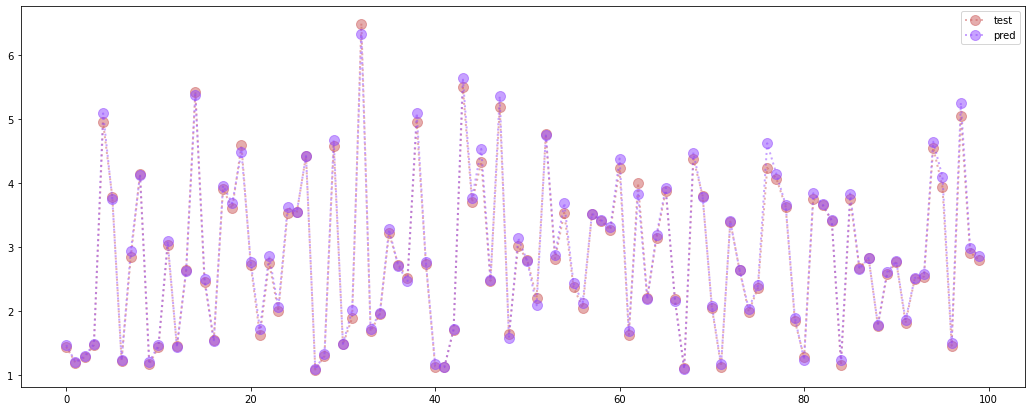

In [606]:
tst = pd.DataFrame(data=y_test, columns=['test'])
tst['test'] = y_test
tst = tst.reset_index(drop=True)
tst['pred'] = predictions
tst[:100].plot(legend=True, linestyle=':', linewidth=2, style=['#CD5C5C', '#9146FF'], marker=".", markersize=20, alpha=0.5)